# Neural machine translation with attention

https://www.tensorflow.org/tutorials/text/nmt_with_attention

## Requirements

In [1]:
import tensorflow as tf

import unicodedata
import re
import numpy as np
import os
import io
import time
import random
import json
import operator
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split

import nltk
from nltk.translate import bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu

from nltk.tag.stanford import StanfordNERTagger
from nltk.tokenize import word_tokenize

## Download and prepare the dataset

In [2]:
path_to_file = "la-en.txt"

In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [4]:
#MAX_LENGTH = 50

#def filterPair(p):
#    return len(p[0].split(' ')) < MAX_LENGTH and \
#        len(p[1].split(' ')) < MAX_LENGTH


#def filterPairs(pairs):
#    return [pair for pair in pairs if filterPair(pair)]

In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  #word_pairs = filterPairs(pairs)

  return zip(*pairs)

In [6]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [7]:
# BLEU score
# Translation quality metrics like BLEU
# are designed to use multiple references of a correct translation. 
# To take this into account during evaluation I combined pairs with an 
# identical source into one pair with one source and multiple targets
def source_target_sents(lang1, lang2):
  source_to_target = {}
  for source, target in zip(lang1, lang2):
      if source in source_to_target:
          source_to_target[source].append(target)
      else:
          source_to_target[source] = [target]
      
  source_sents, target_sents = zip(*source_to_target.items())

  return source_sents, target_sents, source_to_target

In [8]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang, *other = create_dataset(path, num_examples)

  source_sents, target_sents, source_to_target = source_target_sents(inp_lang, targ_lang)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer, source_to_target

In [9]:
# Try experimenting with the size of that dataset
#num_examples = 50000
lines = io.open(path_to_file, encoding='UTF-8').read()
num_examples = len(lines)
input_tensor, target_tensor, inp_lang, targ_lang, source_to_target = load_dataset(path_to_file, num_examples)
print(len(input_tensor), len(target_tensor))

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

62313 62313


In [10]:
random_state = 3

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=random_state)
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor_train, target_tensor_train, test_size=0.1, random_state=random_state)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test))

44865 44865 4985 4985 12463 12463


In [11]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [12]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[5])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
9240 ----> carotas
1014 ----> edere
8 ----> non
225 ----> possum
3 ----> .
25 ----> mihi
8 ----> non
502 ----> placent
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
37 ----> all
5 ----> the
101 ----> people
581 ----> departed
176 ----> every
57 ----> man
9 ----> to
18 ----> his
92 ----> house
6 ----> and
195 ----> david
445 ----> returned
9 ----> to
863 ----> bless
18 ----> his
92 ----> house
3 ----> .
2 ----> <end>


In [13]:
BUFFER_SIZE = len(input_tensor_train)
#BATCH_SIZE = 64
BATCH_SIZE = 100
train_steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
val_steps_per_epoch = len(input_tensor_val)//BATCH_SIZE
embedding_dim = 512
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [14]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([100, 35]), TensorShape([100, 37]))

In [15]:
example_input_batch, example_target_batch = next(iter(val_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([100, 35]), TensorShape([100, 37]))

In [16]:
example_input_batch, example_target_batch = next(iter(test_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([100, 35]), TensorShape([100, 37]))

## Write the encoder and decoder model

In [17]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (100, 35, 1024)
Encoder Hidden state shape: (batch size, units) (100, 1024)


In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [20]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (100, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (100, 35, 1)


In [21]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [22]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (100, 33829)


## Define the optimizer and the loss function

In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

In [25]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [26]:
@tf.function
def valid_step(inp, targ, enc_hidden):
  loss = 0

  enc_output, enc_hidden = encoder(inp, enc_hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    # passing enc_output to the decoder
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss += loss_function(targ[:, t], predictions)

    # using teacher forcing
    dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  return batch_loss

In [27]:
from tqdm.notebook import tqdm

epochs = 0

early_stop_after = 15
early_stop_counter = 0
#minimum_train_loss = 10.0
minimum_val_loss = 10.0

model_loss_history = {'train_loss_history' : [], 'val_loss_history' : []}

total_time_start = time.time()

for epoch in range(100):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_train_loss = 0
  total_val_loss = 0

  # Training
  for (batch, (inp, targ)) in tqdm(enumerate(train_dataset.take(train_steps_per_epoch)), 
                                   desc='Training epoch {}'.format(epoch+1), 
                                   total=train_steps_per_epoch):
    train_batch_loss = train_step(inp, targ, enc_hidden)
    total_train_loss += train_batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Training Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   train_batch_loss.numpy()))
  
  # Validation
  for (batch, (inp, targ)) in tqdm(enumerate(val_dataset.take(val_steps_per_epoch)), 
                                   desc='Val epoch {}'.format(epoch+1), 
                                   total=val_steps_per_epoch):
    val_batch_loss = valid_step(inp, targ, enc_hidden)
    total_val_loss += val_batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Validation Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   val_batch_loss.numpy()))

  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print("<---------------------------------------->")
  print('Epoch {} Training Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1,
                                      total_train_loss / train_steps_per_epoch,
                                      total_val_loss / val_steps_per_epoch))
  
  model_loss_history['train_loss_history'].append((total_train_loss / train_steps_per_epoch).numpy())
  model_loss_history['val_loss_history'].append((total_val_loss / val_steps_per_epoch).numpy())

  print('Time taken for the epoch {} sec\n'.format(time.time() - start))

  epochs += 1

  # Early Stop
  if (total_val_loss/val_steps_per_epoch) < minimum_val_loss:
    early_stop_counter = 0
    print('The best model is found, resetting early stop counter.')
    minimum_val_loss = total_val_loss/val_steps_per_epoch
  else:
    early_stop_counter += 1
    print('No improvements for {} epochs.'.format(early_stop_counter))
    if early_stop_counter >= early_stop_after:
      print('Early stop!')
      break

print('Total Time taken for the training {} sec\n'.format(time.time() - total_time_start))

Epoch 1 Batch 0 Training Loss 3.1653
Epoch 1 Batch 100 Training Loss 1.8358
Epoch 1 Batch 200 Training Loss 1.7963
Epoch 1 Batch 300 Training Loss 1.7696
Epoch 1 Batch 400 Training Loss 1.6185



Epoch 1 Batch 0 Validation Loss 1.8008

<---------------------------------------->
Epoch 1 Training Loss 1.8677 Validation Loss 1.6538
Time taken for the epoch 416.0991497039795 sec

The best model is found, resetting early stop counter.


Epoch 2 Batch 0 Training Loss 1.5389
Epoch 2 Batch 100 Training Loss 1.4627
Epoch 2 Batch 200 Training Loss 1.4396
Epoch 2 Batch 300 Training Loss 1.4038
Epoch 2 Batch 400 Training Loss 1.6914



Epoch 2 Batch 0 Validation Loss 1.4677

<---------------------------------------->
Epoch 2 Training Loss 1.5287 Validation Loss 1.4822
Time taken for the epoch 355.7116560935974 sec

The best model is found, resetting early stop counter.


Epoch 3 Batch 0 Training Loss 1.5356
Epoch 3 Batch 100 Training Loss 1.3120
Epoch 3 Batch 200 Training Loss 1.3629
Epoch 3 Batch 300 Training Loss 1.3357
Epoch 3 Batch 400 Training Loss 1.3475



Epoch 3 Batch 0 Validation Loss 1.3869

<---------------------------------------->
Epoch 3 Training Loss 1.3543 Validation Loss 1.3964
Time taken for the epoch 350.801442861557 sec

The best model is found, resetting early stop counter.


Epoch 4 Batch 0 Training Loss 1.3298
Epoch 4 Batch 100 Training Loss 1.2538
Epoch 4 Batch 200 Training Loss 1.2246
Epoch 4 Batch 300 Training Loss 1.2628
Epoch 4 Batch 400 Training Loss 1.2127



Epoch 4 Batch 0 Validation Loss 1.3761

<---------------------------------------->
Epoch 4 Training Loss 1.2210 Validation Loss 1.3499
Time taken for the epoch 354.6106843948364 sec

The best model is found, resetting early stop counter.


Epoch 5 Batch 0 Training Loss 1.1043
Epoch 5 Batch 100 Training Loss 1.0078
Epoch 5 Batch 200 Training Loss 1.1181
Epoch 5 Batch 300 Training Loss 1.2201
Epoch 5 Batch 400 Training Loss 0.9822



Epoch 5 Batch 0 Validation Loss 1.2630

<---------------------------------------->
Epoch 5 Training Loss 1.0956 Validation Loss 1.3161
Time taken for the epoch 351.15992045402527 sec

The best model is found, resetting early stop counter.


Epoch 6 Batch 0 Training Loss 1.0649
Epoch 6 Batch 100 Training Loss 0.9477
Epoch 6 Batch 200 Training Loss 0.9807
Epoch 6 Batch 300 Training Loss 1.1336
Epoch 6 Batch 400 Training Loss 0.8820



Epoch 6 Batch 0 Validation Loss 1.3904

<---------------------------------------->
Epoch 6 Training Loss 0.9706 Validation Loss 1.2984
Time taken for the epoch 357.1761429309845 sec

The best model is found, resetting early stop counter.


Epoch 7 Batch 0 Training Loss 0.7520
Epoch 7 Batch 100 Training Loss 0.7884
Epoch 7 Batch 200 Training Loss 0.9418
Epoch 7 Batch 300 Training Loss 0.9305
Epoch 7 Batch 400 Training Loss 0.7962



Epoch 7 Batch 0 Validation Loss 1.2203

<---------------------------------------->
Epoch 7 Training Loss 0.8445 Validation Loss 1.2910
Time taken for the epoch 349.3670334815979 sec

The best model is found, resetting early stop counter.


Epoch 8 Batch 0 Training Loss 0.6930
Epoch 8 Batch 100 Training Loss 0.6683
Epoch 8 Batch 200 Training Loss 0.7532
Epoch 8 Batch 300 Training Loss 0.7795
Epoch 8 Batch 400 Training Loss 0.7245



Epoch 8 Batch 0 Validation Loss 1.3565

<---------------------------------------->
Epoch 8 Training Loss 0.7219 Validation Loss 1.2994
Time taken for the epoch 355.4758939743042 sec

No improvements for 1 epochs.


Epoch 9 Batch 0 Training Loss 0.6875
Epoch 9 Batch 100 Training Loss 0.5725
Epoch 9 Batch 200 Training Loss 0.5841
Epoch 9 Batch 300 Training Loss 0.6486
Epoch 9 Batch 400 Training Loss 0.6194



Epoch 9 Batch 0 Validation Loss 1.2598

<---------------------------------------->
Epoch 9 Training Loss 0.6096 Validation Loss 1.3083
Time taken for the epoch 347.9339246749878 sec

No improvements for 2 epochs.


Epoch 10 Batch 0 Training Loss 0.5632
Epoch 10 Batch 100 Training Loss 0.4389
Epoch 10 Batch 200 Training Loss 0.5272
Epoch 10 Batch 300 Training Loss 0.5118
Epoch 10 Batch 400 Training Loss 0.5185



Epoch 10 Batch 0 Validation Loss 1.2285

<---------------------------------------->
Epoch 10 Training Loss 0.5113 Validation Loss 1.3215
Time taken for the epoch 353.26735758781433 sec

No improvements for 3 epochs.


Epoch 11 Batch 0 Training Loss 0.4566
Epoch 11 Batch 100 Training Loss 0.4229
Epoch 11 Batch 200 Training Loss 0.3986
Epoch 11 Batch 300 Training Loss 0.4150
Epoch 11 Batch 400 Training Loss 0.4272



Epoch 11 Batch 0 Validation Loss 1.3760

<---------------------------------------->
Epoch 11 Training Loss 0.4268 Validation Loss 1.3365
Time taken for the epoch 347.9260802268982 sec

No improvements for 4 epochs.


Epoch 12 Batch 0 Training Loss 0.3449
Epoch 12 Batch 100 Training Loss 0.3456
Epoch 12 Batch 200 Training Loss 0.3546
Epoch 12 Batch 300 Training Loss 0.4181
Epoch 12 Batch 400 Training Loss 0.3729



Epoch 12 Batch 0 Validation Loss 1.3914

<---------------------------------------->
Epoch 12 Training Loss 0.3547 Validation Loss 1.3581
Time taken for the epoch 352.29364228248596 sec

No improvements for 5 epochs.


Epoch 13 Batch 0 Training Loss 0.3101
Epoch 13 Batch 100 Training Loss 0.3090
Epoch 13 Batch 200 Training Loss 0.3157
Epoch 13 Batch 300 Training Loss 0.2630
Epoch 13 Batch 400 Training Loss 0.2790



Epoch 13 Batch 0 Validation Loss 1.3995

<---------------------------------------->
Epoch 13 Training Loss 0.2927 Validation Loss 1.3793
Time taken for the epoch 348.6200542449951 sec

No improvements for 6 epochs.


Epoch 14 Batch 0 Training Loss 0.2553
Epoch 14 Batch 100 Training Loss 0.2273
Epoch 14 Batch 200 Training Loss 0.2472
Epoch 14 Batch 300 Training Loss 0.2429
Epoch 14 Batch 400 Training Loss 0.3049



Epoch 14 Batch 0 Validation Loss 1.4126

<---------------------------------------->
Epoch 14 Training Loss 0.2417 Validation Loss 1.4037
Time taken for the epoch 354.1885566711426 sec

No improvements for 7 epochs.


Epoch 15 Batch 0 Training Loss 0.2072
Epoch 15 Batch 100 Training Loss 0.1803
Epoch 15 Batch 200 Training Loss 0.1999
Epoch 15 Batch 300 Training Loss 0.2404
Epoch 15 Batch 400 Training Loss 0.2023



Epoch 15 Batch 0 Validation Loss 1.4338

<---------------------------------------->
Epoch 15 Training Loss 0.2013 Validation Loss 1.4287
Time taken for the epoch 349.97819113731384 sec

No improvements for 8 epochs.


Epoch 16 Batch 0 Training Loss 0.1419
Epoch 16 Batch 100 Training Loss 0.1354
Epoch 16 Batch 200 Training Loss 0.1596
Epoch 16 Batch 300 Training Loss 0.1600
Epoch 16 Batch 400 Training Loss 0.1826



Epoch 16 Batch 0 Validation Loss 1.3213

<---------------------------------------->
Epoch 16 Training Loss 0.1692 Validation Loss 1.4591
Time taken for the epoch 355.9441533088684 sec

No improvements for 9 epochs.


Epoch 17 Batch 0 Training Loss 0.1230
Epoch 17 Batch 100 Training Loss 0.1071
Epoch 17 Batch 200 Training Loss 0.1066
Epoch 17 Batch 300 Training Loss 0.1528
Epoch 17 Batch 400 Training Loss 0.1397



Epoch 17 Batch 0 Validation Loss 1.6614

<---------------------------------------->
Epoch 17 Training Loss 0.1421 Validation Loss 1.4758
Time taken for the epoch 353.3552277088165 sec

No improvements for 10 epochs.


Epoch 18 Batch 0 Training Loss 0.1285
Epoch 18 Batch 100 Training Loss 0.1202
Epoch 18 Batch 200 Training Loss 0.1212
Epoch 18 Batch 300 Training Loss 0.1227
Epoch 18 Batch 400 Training Loss 0.1153



Epoch 18 Batch 0 Validation Loss 1.4951

<---------------------------------------->
Epoch 18 Training Loss 0.1230 Validation Loss 1.5053
Time taken for the epoch 357.4173536300659 sec

No improvements for 11 epochs.


Epoch 19 Batch 0 Training Loss 0.0825
Epoch 19 Batch 100 Training Loss 0.1122
Epoch 19 Batch 200 Training Loss 0.1113
Epoch 19 Batch 300 Training Loss 0.1242
Epoch 19 Batch 400 Training Loss 0.1014



Epoch 19 Batch 0 Validation Loss 1.7838

<---------------------------------------->
Epoch 19 Training Loss 0.1081 Validation Loss 1.5256
Time taken for the epoch 354.16500210762024 sec

No improvements for 12 epochs.


Epoch 20 Batch 0 Training Loss 0.0776
Epoch 20 Batch 100 Training Loss 0.0824
Epoch 20 Batch 200 Training Loss 0.1023
Epoch 20 Batch 300 Training Loss 0.0972
Epoch 20 Batch 400 Training Loss 0.1198



Epoch 20 Batch 0 Validation Loss 1.3370

<---------------------------------------->
Epoch 20 Training Loss 0.0971 Validation Loss 1.5562
Time taken for the epoch 357.6851816177368 sec

No improvements for 13 epochs.


Epoch 21 Batch 0 Training Loss 0.0702
Epoch 21 Batch 100 Training Loss 0.0814
Epoch 21 Batch 200 Training Loss 0.0849
Epoch 21 Batch 300 Training Loss 0.0739
Epoch 21 Batch 400 Training Loss 0.0950



Epoch 21 Batch 0 Validation Loss 1.7731

<---------------------------------------->
Epoch 21 Training Loss 0.0893 Validation Loss 1.5743
Time taken for the epoch 353.6153612136841 sec

No improvements for 14 epochs.


Epoch 22 Batch 0 Training Loss 0.0855
Epoch 22 Batch 100 Training Loss 0.0874
Epoch 22 Batch 200 Training Loss 0.0893
Epoch 22 Batch 300 Training Loss 0.0864
Epoch 22 Batch 400 Training Loss 0.1185



Epoch 22 Batch 0 Validation Loss 1.6922

<---------------------------------------->
Epoch 22 Training Loss 0.0839 Validation Loss 1.6028
Time taken for the epoch 357.6162931919098 sec

No improvements for 15 epochs.
Early stop!
Total Time taken for the training 7834.431691408157 sec



In [28]:
def plot_model_history(model_history):
  
  rows, cols = 1, 2
  fig, axs = plt.subplots(rows, cols, figsize=(15, 5))
    
  # summarize history for train_loss
  axs[0].plot(range(1, len(model_history['train_loss_history'])+1), 
              model_history['train_loss_history'], 
              color = 'blue')
  axs[0].scatter(range(1, len(model_history['train_loss_history'])+1), 
                 model_history['train_loss_history'], 
                 color = 'blue')
  axs[0].set_title('Train Loss')
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_xticks(np.arange(epochs+1))
  axs[0].legend(['train'], loc='best')



  # summarize history for val_loss
  axs[1].plot(range(1, len(model_history['val_loss_history'])+1), 
              model_history['val_loss_history'], 
              color = 'red')
  axs[1].scatter(range(1, len(model_history['val_loss_history'])+1), 
                 model_history['val_loss_history'], 
                 color = 'red')
  axs[1].set_title('Val Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epochs')
  axs[1].set_xticks(np.arange(epochs+1))
  axs[1].legend(['val'], loc='best')

  plt.show()

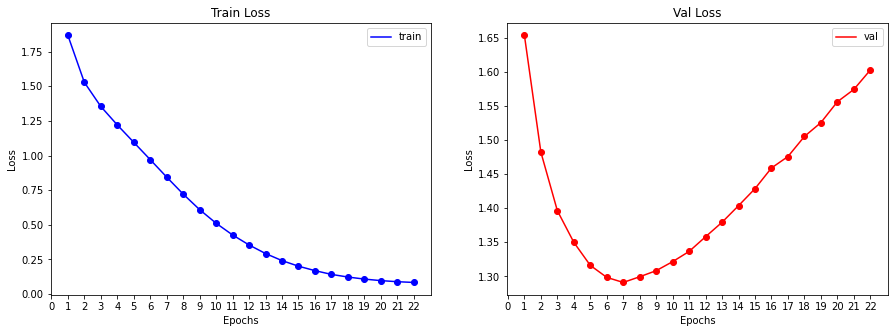

In [29]:
plot_model_history(model_loss_history)

## Translate

In [30]:
def evaluate(sentence):

  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')

  inputs = tf.convert_to_tensor(inputs)


  result = ''

  hidden = [tf.zeros((1, units))]


  enc_out, enc_hidden = encoder(inputs, hidden)


  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):

    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [31]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [32]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [33]:
def translate2(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))
  
  return result, sentence, attention_plot

## Restore the latest checkpoint and test

In [34]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [60]:
model = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## BLEU

In [35]:
def tensor2sentence(lang, tensor):
  sentence = ""
  for t in tensor:
    if t!=0:
      sentence += lang.index_word[t] + " "
  return sentence

In [36]:
def tensor2set(tensor_set, lang):
  list = []
  for tensor in tensor_set:
    sentence = tensor2sentence(lang, tensor)
    list.append(sentence)
  
  return list

In [37]:
def multiple_target(sentence, dict):
  targets = []
  for key, value in dict.items():
    if key == sentence and len(value) > 1:
      targets += (value)
  return targets

In [38]:
source_sents_test = tensor2set(input_tensor_test, inp_lang)

In [39]:
def sent_choice(sents_set, source_target_sents):

  full_sent = random.choice(source_sents_test).strip()
  targets = multiple_target(full_sent, source_target_sents)

  if len(targets) > 3:
    print(full_sent)
    print(len(targets))
    return full_sent, targets
  else:
    return sent_choice(sents_set, source_target_sents)

In [40]:
full_sent, targets = sent_choice(source_sents_test, source_to_target)

<start> bovem de armento et arietem et agnum anniculum in holocaustum <end>
22


In [41]:
short_sent = full_sent.lstrip("<start>").rstrip("<end>").strip()

In [42]:
short_sent

'bovem de armento et arietem et agnum anniculum in holocaustum'

Input: <start> bovem de armento et arietem et agnum anniculum in holocaustum <end>
Predicted translation: one young bull , one ram , one male lamb a year old , for a burnt offering <end> 


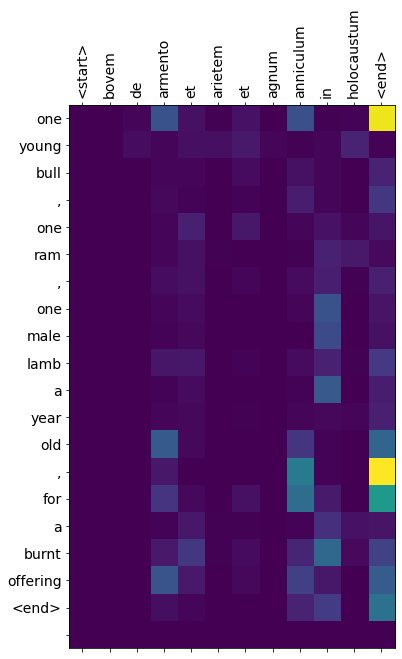

In [43]:
translation, sentence, attention_plot = translate2(short_sent)

In [44]:
def clean_references(targets):
  reference = []
  for t in targets:
    t = t.lstrip("<start> ")
    t = t.rstrip(" <end>")
    reference.append(t.split())

  return reference

In [45]:
reference = clean_references(targets)

In [46]:
print(len(reference))

22


In [47]:
short_sent = short_sent.split()

In [48]:
short_sent

['bovem',
 'de',
 'armento',
 'et',
 'arietem',
 'et',
 'agnum',
 'anniculum',
 'in',
 'holocaustum']

While matching sentences you can choose the number of words you want the model to match at once.
You can also choose for words to be matched one at a time (1-gram), or to match words in pairs (2-gram) or triplets (3-grams)...


BLEU non è mai stato creato pensando al confronto del livello di frase, ecco una bella discussione: https://github.com/nltk/nltk/issues/1838 Molto probabilmente, vedrai l'avviso quando hai frasi molto brevi

In [49]:
print('Individual 1-gram: %f' % sentence_bleu(reference, short_sent, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, short_sent, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, short_sent, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, short_sent, weights=(0, 0, 0, 1)))

Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


By default the sentence_bleu() function calculates the cumulative 4-gram BLEU score, also called BLEU-4. The weights for BLEU-4 are as follows :

In [50]:
score = sentence_bleu(reference, short_sent, weights=(0.25, 0.25, 0.25, 0.25))
print('BLEU-4: %f' % score)

BLEU-4: 0.000000


You can use the smoothing functions in https://github.com/alvations/nltk/blob/develop/nltk/translate/bleu_score.py#L425 to overcome short sentences.



This is an implementation of the smoothing techniques for segment-level BLEU scores that was presented in Boxing Chen and Collin Cherry (2014) A Systematic Comparison of Smoothing Techniques for Sentence-Level BLEU. In WMT14.
http://acl2014.org/acl2014/W14-33/pdf/W14-3346.pdf

In [51]:
smoothie = SmoothingFunction().method4
bleu(reference, short_sent, smoothing_function=smoothie)

0

## Predictions

Input: <start> hodie si frigus valde serenum est . <end>
Predicted translation: it is the best better to eat . <end> 


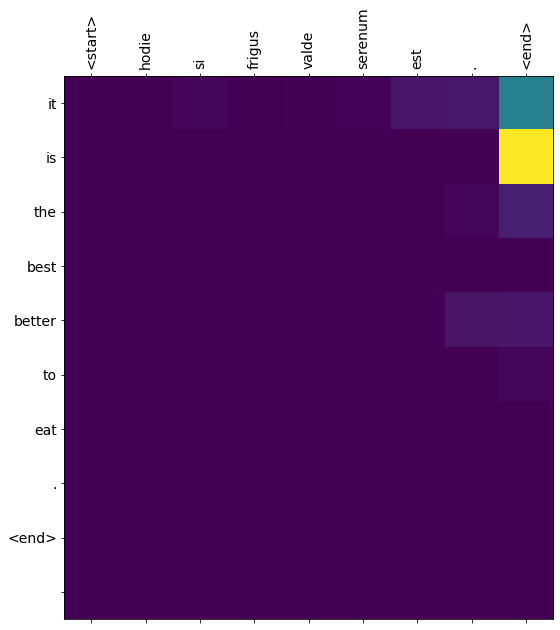

In [52]:
translate(u'hodie si frigus valde serenum est .')

Input: <start> tom cum romam venit tu quoque ? <end>
Predicted translation: did you know where tom ? <end> 


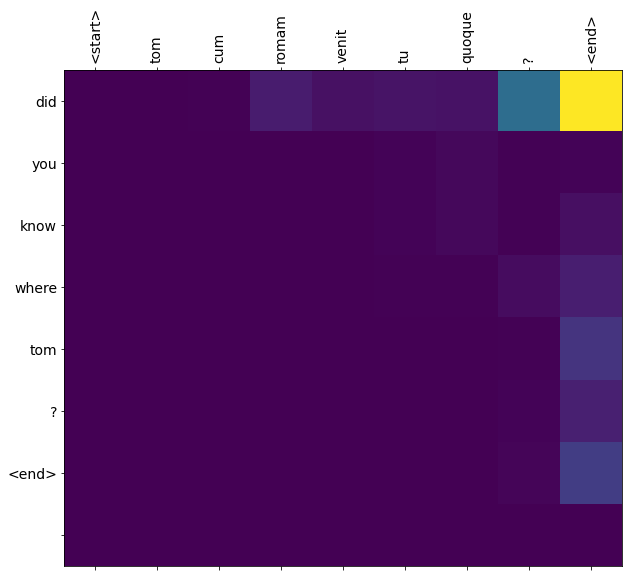

In [53]:
translate(u'tom cum romam venit tu quoque ?')

## Attention Weights

Input: <start> bovem de armento et arietem et agnum anniculum in holocaustum <end>
Predicted translation: one young bull , one ram , one male lamb a year old , for a burnt offering <end> 


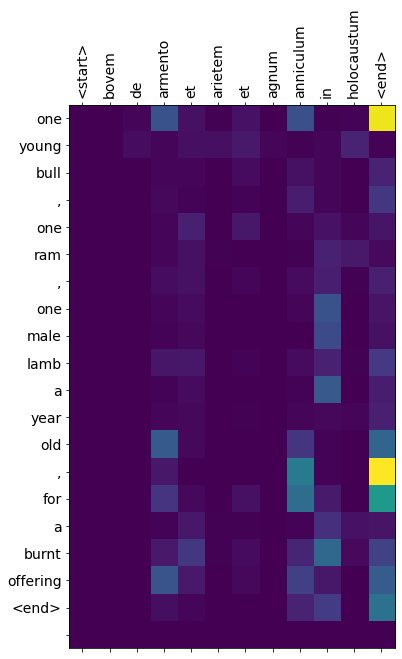

In [54]:
sentence = full_sent.lstrip("<start>").rstrip("<end>").strip()
outputs, inputs, attention_plot = translate2(sentence)

In [55]:
column_index2token = defaultdict(str)

for i, token in enumerate(inputs.split()):

  column_index2token[i] = token

column_index2token


row_index2token = defaultdict(str)

for i, token in enumerate(outputs.split()):

  row_index2token[i] = token

row_index2token

defaultdict(str,
            {0: 'one',
             1: 'young',
             2: 'bull',
             3: ',',
             4: 'one',
             5: 'ram',
             6: ',',
             7: 'one',
             8: 'male',
             9: 'lamb',
             10: 'a',
             11: 'year',
             12: 'old',
             13: ',',
             14: 'for',
             15: 'a',
             16: 'burnt',
             17: 'offering',
             18: '<end>'})

In [56]:
def translate2attn(result, sentence, attention_plot):

  translation_weights = {}

  for i, token in enumerate(result.split()):

    translation_weights[token] = {}

    for j, tkn in enumerate(sentence.split()):

      translation_weights[token][tkn] = attention_plot[i][j]

  return translation_weights

In [57]:
def attn2json(translation_weights):
  
  with open('attention_weights.json', 'w') as fp:
    json.dump(translation_weights, fp)

In [58]:

def translation_prediction(translation_weights):

  translation_prediction = {}

  for key, value in translation_weights.items():
    maximum = max(value, key=value.get)
    translation_prediction[key] = maximum

  return translation_prediction


In [59]:
#print("inputs: {}".format(inputs))
#print("outputs: {}".format(outputs))
#print("attention_plot: {}".format(attention_plot))

translation_weights = translate2attn(outputs, inputs, attention_plot)

translation_prediction(translation_weights)

#attn2json(translation_weights)

{',': '<end>',
 '<end>': '<end>',
 'a': 'in',
 'bull': '<end>',
 'burnt': 'in',
 'for': '<end>',
 'lamb': '<end>',
 'male': 'in',
 'offering': '<end>',
 'old': '<end>',
 'one': 'in',
 'ram': 'in',
 'year': '<end>',
 'young': 'holocaustum'}